In [46]:
from urllib.request import  urlopen
import urllib
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import datetime
import geopy

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By




    
    
#Парсер с каждой страницы собирает инфу по всем находящимся на ней объяевлениям о квартирах
#tag - берется из beautiful-soup, ищется по классу контейнера на странице
def parse_tag(tag):
    try:
        return {'price': tag.find_all("span", {"class": "long-item-card__price___3A6JF"})[0].text,
                   'description': tag.find_all("span", {"class": "long-item-card__title___16K7W"})[0].text, 
                   'add_info': tag.find_all("div", {"class": "additional-price-info__additionalPriceInfo___lBqNv"})[0].text, 
                   'address': tag.find_all("span", {"class": "long-item-card__address___PVI5p"})[0].text,
                   'link' : tag["href"],
                   'creation_timestamp' : time.strftime('%Y-%m-%d %H:%M:%S')}
    except Exception:   
        return {
                    'price':'',
                    'description':'', 
                    'add_info' : '', 
                    'address' : '', 
                    'link': '', 
                    'creation_timestamp':''
        }
    


flats = []
url_base = "https://www.domofond.ru/arenda-odnokomnatnyh-kvartir-moskva-c3584?RentalRate=Month"

def parse_page(url):
    flats_out = []
    driver = webdriver.Chrome()
    driver.get(url)
    content = driver.page_source
    soup = BeautifulSoup(content, 'lxml')
    driver.close()
    for tag in soup.find_all("a", {"class": "long-item-card__item___ubItG search-results__itemCardNotFirst___3fei6"}):
        flats_out += [parse_tag(tag)]             
    return flats_out, soup
    
flats_first, soup = parse_page(url)
flats += flats_first
page_count = int(soup.find_all("li",{"class":"pagination__page___2dfw0"})[-1].text)

for page in range(page_count):
    print(str(page) + " / " + str(page_count) + " прогресс из всех страниц", end = '\r', flush = True)
    time.sleep(10) 
    flats += parse_page(url+"&Page="+str(page+1))[0]

        


In [47]:
import pickle
with open('flats.pkl','wb') as outp:
    pickle.dump(flats, outp, pickle.HIGHEST_PROTOCOL)

In [59]:
def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return 0

data = pd.DataFrame(flats)
data["price_val"] = [int(''.join([s for s in price if s.isdigit()])) for price in data.price]
data["descr_numbers"] = data.description.apply(lambda x: re.findall(r'[0-9]+', x))
data["rooms"] = data.descr_numbers.apply(lambda x: int(x[0]))
data["surface"] = data.descr_numbers.apply(lambda x: int(x[1]))
data["floor"] = data.descr_numbers.apply(lambda x: int(x[-2]))
data["floors_total"] = data.descr_numbers.apply(lambda x: int(x[-1]))
data["commiss"] = [catch(lambda : int(re.search('Комиссия: (\d+)', s).group(1))) for s in data.add_info]
data["deposit"] = [catch(lambda : re.search('Залог: (\d+ \d+)', s).group(1)) for s in data.add_info]
data["deposit"] = [int(''.join([s for s in str(price) if s.isdigit()])) for price in data.deposit]


In [95]:
import geopy
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
geolocator =  geopy.geocoders.Nominatim(user_agent="azunyan")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
data["geoloc"] = data['address'].apply(partial(geocode, addressdetails=True))


AttributeError: 'NoneType' object has no attribute 'raw'

In [99]:
with open('data_flats.pkl','wb') as outp:
    pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)

In [11]:
import pickle
import pandas as pd
with open('data_flats.pkl', 'rb') as f:
    x = pickle.load(f)

In [5]:
data = x

In [6]:
def trycoord(value):
    try:
        return value.raw['boundingbox']
    except:
        return ['0', '0', '0', '0']

data['coord'] = [trycoord(geo) for geo in data["geoloc"].values]
data["coord_x"] = data.coord.apply(lambda x: (float(x[0]) +float(x[1]))/2)
data["coord_y"] = data.coord.apply(lambda x: (float(x[2]) +float(x[3]))/2)

In [7]:
data_clean = data.drop(columns = ["price", "add_info", "descr_numbers"])


In [8]:
data_clean.head()

,description,address,link,creation_timestamp,price_val,rooms,surface,floor,floors_total,commiss,deposit,geoloc,coord,coord_x,coord_y
0,"1-комн. квартира, 50.8 м², 3/25 эт.","Москва, бульвар Яна Райниса, 31",/1-komnatnaya-kvartira-v-arendu-moskva-2919433393,2022-10-08 16:31:50,55000,1,50,3,25,0,82500,"(Бульвар Яна Райниса, 31, бульвар Яна Райниса,...","[55.84879, 55.84889, 37.41949, 37.41959]",55.848840,37.419540
1,"1-комн. квартира, 30 м², 2/5 эт.","Москва, проспект Будённого, 41",/1-komnatnaya-kvartira-v-arendu-moskva-4781140560,2022-10-08 16:31:50,45000,1,30,2,5,0,45000,"(41/17, проспект Будённого, район Соколиная Го...","[55.7633666, 55.7636813, 37.7351631, 37.735995]",55.763524,37.735579
2,"1-комн. квартира, 53 м², 12/21 эт.","Москва, Ярославское шоссе, 146к2",/1-komnatnaya-kvartira-v-arendu-moskva-187702165,2022-10-08 16:31:50,46000,1,53,12,21,0,92000,"(146 к2, Ярославское шоссе, Ярославский район,...","[55.8789036, 55.8790036, 37.729404, 37.729504]",55.878954,37.729454
3,"1-комн. квартира, 34 м², 6/12 эт.","Москва, Хабаровская улица, 1",/1-komnatnaya-kvartira-v-arendu-moskva-2105162040,2022-10-08 16:31:50,38000,1,34,6,12,0,38000,"(1, Хабаровская улица, район Гольяново, Москва...","[55.8140283, 55.8147619, 37.8268865, 37.8271314]",55.814395,37.827009
4,"1-комн. квартира, 40 м², 17/17 эт.","Москва, Новочерёмушкинская улица, 52к2",/1-komnatnaya-kvartira-v-arendu-moskva-2578164432,2022-10-08 16:31:50,55000,1,40,17,17,50,55000,"(52 к2, Новочерёмушкинская улица, район Черёму...","[55.6699926, 55.6710069, 37.5625115, 37.563421]",55.670500,37.562966


In [9]:
num_features = ['rooms', 'surface', 'floor', 'floors_total', 'coord_x', 'coord_y']

In [166]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(data_clean[num_features].values), 
             columns = data_clean[num_features].columns)


,rooms,surface,floor,floors_total,coord_x,coord_y
0,0.0,1.324783,-0.653804,0.727184,0.312822,0.288949
1,0.0,-0.953286,-0.770965,-0.921638,0.307358,0.318955
2,0.0,1.666494,0.400638,0.397419,0.314751,0.318374
3,0.0,-0.497673,-0.302324,-0.344551,0.310616,0.327636
4,0.0,0.185748,0.986439,0.067655,0.301400,0.302567
...,...,...,...,...,...,...
4645,0.0,-0.725479,-0.653804,-0.921638,0.309573,0.326562
4646,0.0,-0.042059,-0.770965,-0.591874,0.305271,0.307041
4647,0.0,-0.155962,1.220759,0.232537,0.303329,0.338706
4648,0.0,-0.497673,0.166317,-0.344551,0.303941,0.319603


In [167]:
X = data_clean[num_features].values
X = scaler.fit_transform(data_clean[num_features].values)

In [168]:
len(X)

4650

In [255]:
#X = flats_nonzero[['coord_x', 'coord_y']].values
#X = flats_nonzero[num_features].values

In [234]:
y = data_clean.price_val.values
y = np.log(y)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33)

In [292]:
!pip install xgboost

In [249]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33)
#clf = GradientBoostingRegressor(loss='ls', n_estimators=100, learning_rate=0.8,
#    max_depth=1).fit(X_train, y_train)

#clf = BaggingRegressor(n_estimators=100)

#clf = XGBRegressor()
#сlf = KNeighborsRegressor()
clf = XGBRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.582646555041705

In [250]:
param_grid = { 
    'booster': ['gbtree', 'gblinear'],
    'eta': [0.1, 0.3, 0.5],
    'gamma': [0, 0.1, 0.5, 1, 10],
    'max_depth' : [4,5,6]
}
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv= 5)


In [60]:
clf.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [251]:
CV_rfc.fit(X_train, y_train)

[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

[17:30:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:30:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth" } might n

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...ot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
     

In [222]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfc.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfc.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfc.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0, ...)

 The best score across ALL searched params:
 -5.1888368484201814

 The best parameters across ALL searched params:
 {'booster': 'gblinear'}


In [223]:

CV_rfc.score(X_test, y_test)

-2.52157899002126

In [151]:
clf.score(X_test, y_test)

2.1889558359022843e-05

In [152]:
clf.predict([X_test[1]])

array([37000.])

In [153]:
y_test[1]

38000

In [209]:
y_test[1]

60000

In [302]:
clf.get_booster().get_score()

{'f1': 812.0, 'f2': 527.0, 'f3': 460.0, 'f4': 935.0, 'f5': 839.0}

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [89]:
CV_rfc.score(X, y)

0.0010390683781519305

In [154]:
import numpy as np
np.mean(y_test - clf.predict(X_test))

49897.37328990228

In [155]:
np.abs(np.mean(np.abs(y_test - CV_rfc.predict(X_test))))

85289.85466968648

In [92]:
np.abs(np.median(np.abs(y_test - CV_rfc.predict(X_test))))

35632.734375

In [224]:
x_me = [1, 37, 3, 16, 55.6808939, 37.749387]
CV_rfc.predict([x_me])

array([2458463.2], dtype=float32)

In [280]:
np.mean([37.7568874, 37.7583617])

37.75762455

In [288]:
clf.predict([x_me])

array([39273.32333333])

In [225]:
import matplotlib.pyplot as plt


(array([4.648e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.50000e+04, 6.96350e+06, 1.39120e+07, 2.08605e+07, 2.78090e+07,
        3.47575e+07, 4.17060e+07, 4.86545e+07, 5.56030e+07, 6.25515e+07,
        6.95000e+07]),
 <BarContainer object of 10 artists>)

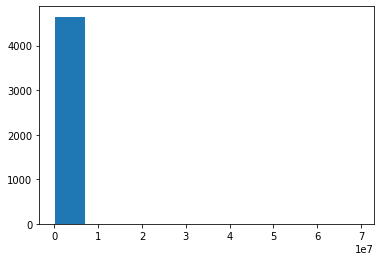

In [228]:
plt.hist(y)

(array([7.070e+02, 3.594e+03, 2.900e+02, 5.500e+01, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 9.61580548, 10.45990866, 11.30401185, 12.14811503, 12.99221821,
        13.8363214 , 14.68042458, 15.52452776, 16.36863094, 17.21273413,
        18.05683731]),
 <BarContainer object of 10 artists>)

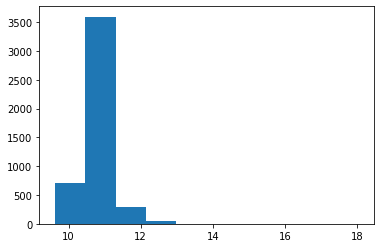

In [231]:
plt.hist((np.log(y)))

In [256]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Azunyan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [259]:
stopwords.words('')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на